In [212]:
import Pkg
Pkg.activate("../../.")

  Activating project at `~/Documents/MPSTime.jl`


In [226]:
using Plots
using DelimitedFiles
using MPSTime
using StatsBase
using StatsPlots
using ITensors
using Normalization
using LaTeXStrings
using Plots.PlotMeasures
default(;fontfamily = "Computer Modern", xtickfont=12, ytickfont=12, guidefont=12, 
    bottom_margin=8mm, left_margin=8mm, right_margin=8mm, titlefont=12, c=palette(:tab10))

In [2]:
sliding_window(ts::Vector, w::Int, s::Int) = [[i:min(i+w-1, length(ts))] for i in 1:s:length(ts)-w+1]

sliding_window (generic function with 1 method)

# Dataset 1

In [3]:
fstyle = font("Computer Modern", 14);

In [4]:
dpath = "../UCR_Data/";
# only load in the datasets from the specified subset
subset = readdlm("../preprocessing/UCR_subset.txt")[:, 1];

total length: 79795 samples
train length: 35000 samples
test length: 44796 samples
anomaly length: 620 samples


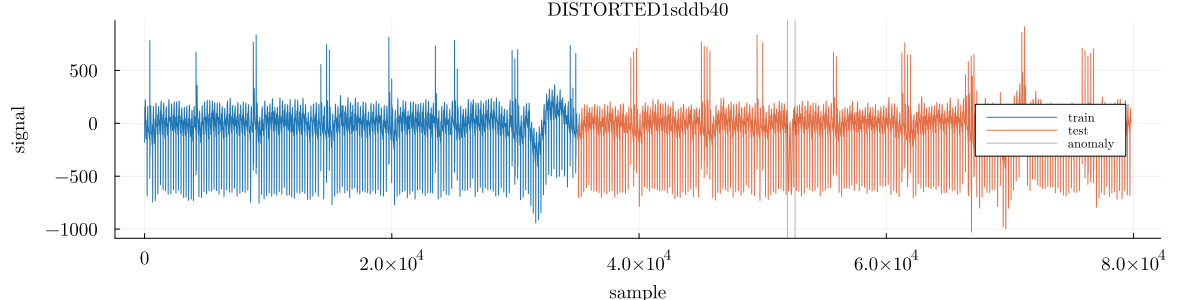

In [5]:
d1 = readdlm(dpath * subset[1])[:, 1];
dstring = (split(subset[1], "_"))
dname = dstring[4]
tidx_end = parse(Int, dstring[5])
tidx_anom_start = parse(Int, dstring[6])
tidx_anom_end = parse(Int, split(dstring[7], ".")[1]);
# make datasets
train = d1[1:tidx_end]
test = d1[tidx_end+1:end]
# basic stats
println("total length: $(length(d1)) samples")
println("train length: $(length(collect(1:tidx_end))) samples")
println("test length: $(length(collect(tidx_end:length(d1)))) samples")
println("anomaly length: $(tidx_anom_end-tidx_anom_start) samples")
xs = collect(1:length(d1))
p1 = plot(xs[1:tidx_end], d1[1:tidx_end], label="train", title=dname, xlabel="sample", ylabel="signal", size=(1200, 300), legend=:right)
p1 = plot!(xs[tidx_end+1:end], d1[tidx_end+1:end], label="test", c=2)
p1 = vline!([tidx_anom_start, tidx_anom_end], label="anomaly", c=:black, alpha=0.3)

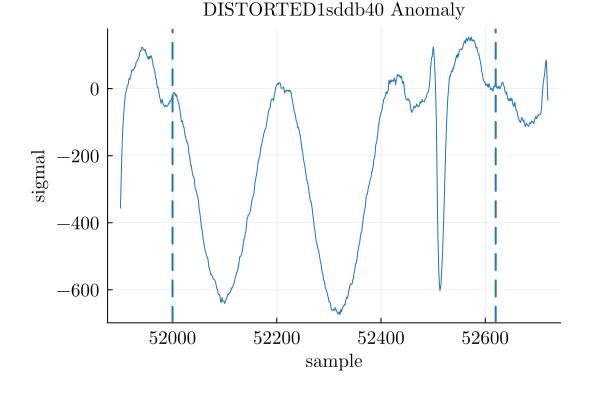

In [6]:
p2 = plot(xs[tidx_anom_start-100:tidx_anom_end+100], d1[tidx_anom_start-100:tidx_anom_end+100], xlabel="sample", ylabel="sigmal", label="")
vline!([tidx_anom_start, tidx_anom_end], label="", title="$dname Anomaly", lw=2, ls=:dash)

In [183]:
window_sizes = [4, 16, 32, 64, 128, 256, 512];

In [ ]:
window_probabilities = Vector{Vector}(undef, length(window_sizes));
opts = MPSOptions(d=8, chi_max=50, nsweeps=20, eta=0.1, sigmoid_transform=false);
for (iw, wsize) in enumerate(window_sizes)
    train_window_idxs = sliding_window(train, wsize, wsize) # just extract the idxs 
    test_window_idxs = sliding_window(test, wsize, wsize)
    train_final = hcat([train[i...] for i in train_window_idxs]...)' |> Matrix 
    test_final = hcat([test[i...] for i in test_window_idxs]...)' |> Matrix 
    mps_trained, _, _  = fitMPS(train_final, opts)
    imp = init_imputation_problem(mps_trained, test_final)
    mps = imp.mpss[1]
    sites = siteinds(mps)
    train_window_scaled, norms = MPSTime.transform_train_data(imp.X_train; opts=imp.opts)
    test_windows_scaled, _ = MPSTime.transform_test_data(imp.X_test, norms; opts=imp.opts);
    test_encoded = [MPS([itensor(MPSTime.get_state(x, imp.opts, j, imp.enc_args), sites[j]) for (j, x) in enumerate(test_windows_scaled[i, :])]) for i in 1:size(test_windows_scaled, 1)];
    probas = []
    for ps in test_encoded
        overlap = 1.0
        for i in eachindex(mps)
            overlap *= mps[i] * ps[i]
        end
        proba = log10(abs2(scalar(overlap)))
        push!(probas, proba)
    end
    window_probabilities[iw] = probas
end

Generating initial weight MPS with bond dimension χ_init = 4
        using random state 1234.
Initialising train states.
blas_name = "LBTConfig([ILP64] libopenblas64_.dylib)"
Using 1 iterations per update.
Training KL Div. 6.144244362210535 | Training acc. 1.0.

┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715



Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/20]
Backward sweep finished.
Starting forward sweep: [1/20]
Finished sweep 1. Time for sweep: 1.01s
Training KL Div. -0.6202972295220146 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/20]
Backward sweep finished.
Starting forward sweep: [2/20]
Finished sweep 2. Time for sweep: 1.15s
Training KL Div. -1.900073632575212 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/20]
Backward sweep finished.
Starting forward sweep: [3/20]
Finished sweep 3. Time for sweep: 1.16s
Training KL Div. -2.375977014487915 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/20]
Backward sweep finished.
Starting forward sweep: [4/20]
Finished sweep 4. Time for sweep: 1.12s
Training KL Div. -2.5451192136891234 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorith

┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715



Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/20]
Backward sweep finished.
Starting forward sweep: [1/20]
Finished sweep 1. Time for sweep: 9.06s
Training KL Div. -11.806414625088875 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/20]
Backward sweep finished.
Starting forward sweep: [2/20]
Finished sweep 2. Time for sweep: 25.19s
Training KL Div. -12.375843129093509 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/20]
Backward sweep finished.
Starting forward sweep: [3/20]
Finished sweep 3. Time for sweep: 26.94s
Training KL Div. -12.43077839644414 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/20]
Backward sweep finished.
Starting forward sweep: [4/20]
Finished sweep 4. Time for sweep: 25.68s
Training KL Div. -12.414956714219745 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algo

┌ Warning: Not using MKL BLAS, which may lead to worse performance.
│ To fix this, Import MPSTime into Julia first or use the MKL package
└ @ MPSTime /Users/jmoo2880/Documents/MPSTime.jl/src/Training/RealRealHighDimension.jl:715



Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [1/20]
Backward sweep finished.
Starting forward sweep: [1/20]
Finished sweep 1. Time for sweep: 11.58s
Training KL Div. -26.06576042150242 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [2/20]
Backward sweep finished.
Starting forward sweep: [2/20]
Finished sweep 2. Time for sweep: 31.31s
Training KL Div. -26.716435070564856 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [3/20]
Backward sweep finished.
Starting forward sweep: [3/20]
Finished sweep 3. Time for sweep: 32.31s
Training KL Div. -26.811361486071675 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" algorithm
Starting backward sweeep: [4/20]
Backward sweep finished.
Starting forward sweep: [4/20]
Finished sweep 4. Time for sweep: 32.08s
Training KL Div. -26.849174848590863 | Training acc. 1.0.
Using optimiser CustomGD with the "TSGO" alg

In [97]:
window_probabilities[1]

11198-element Vector{Any}:
 1.238703153218297
 1.2289454317063364
 1.212155507200966
 1.232941458164572
 1.2616917564937256
 1.2869755439000192
 1.2910465590370257
 1.3120517490162042
 1.258845768375428
 1.262530814500836
 ⋮
 1.2805559623181948
 1.2858104609112047
 1.277218837707178
 1.3213590994502853
 1.4133141241731475
 1.4333618689393899
 1.4457403807584095
 1.4324461833609305
 1.4218855680529947

In [185]:
window_sizes = [4, 16, 32, 64, 128, 256, 512];
M = fill(NaN, length(window_sizes), length(test))
for (iw, wsize) in enumerate(window_sizes)
    println(wsize)
    widxs = sliding_window(collect(1:length(test)), wsize, wsize)
    for (iiw, widx) in enumerate(widxs)
        window_proba = fill(window_probabilities[iw][iiw], wsize)
        M[iw, widx[1]] = window_proba
    end
end

4
16
32
64
128
256
512


In [197]:
@show maximum(filter(!isnan,M));
@show minimum(filter(!isnan,M));

maximum(filter(!isnan, M)) = 199.30411388431398
minimum(filter(!isnan, M)) = -4.711281148488788


Normalise the values along the rows, so that comparisons can be made within a given window size row

In [252]:
# normalised version
N = nansafe(MinMax)
mm_fit = fit(N, M; dims=[2])
M_norm = mm_fit(M);

Determine the location of the anomaly relative to the test set start

In [304]:
test_start = tidx_end + 1
test_anomaly_start = (tidx_anom_start - test_start) + 1
test_anomaly_end = (tidx_anom_end - test_start) + 1
@show d1[tidx_anom_start];
@show test[test_anomaly_start];
@show d1[tidx_anom_end];
@show test[test_anomaly_end];

d1[tidx_anom_start] = -23.607149
test[test_anomaly_start] = -23.607149
d1[tidx_anom_end] = 14.664994
test[test_anomaly_end] = 14.664994


In [325]:
opts.nsweeps

15

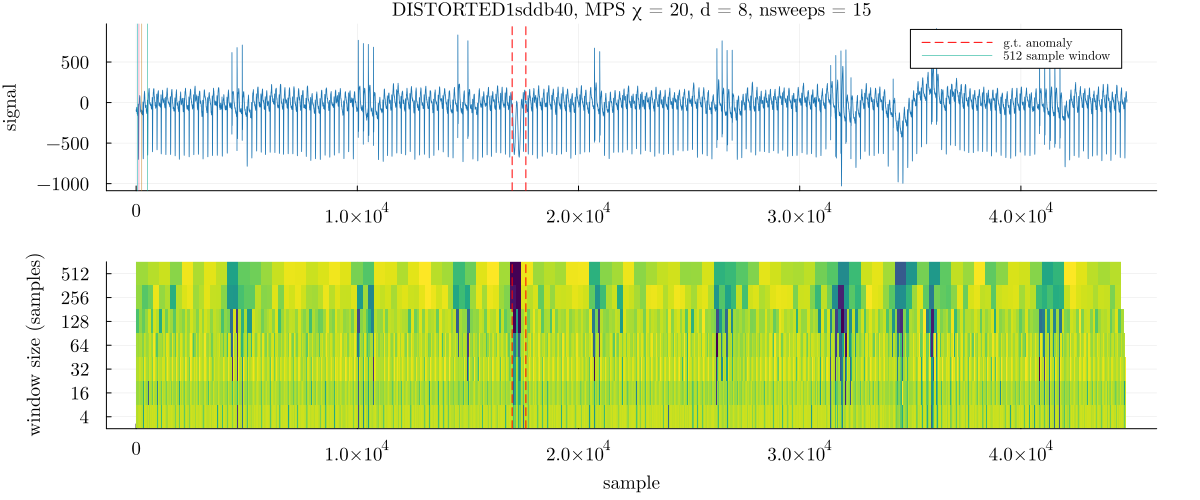

In [350]:
p1 = plot(collect(1:length(test)), test, label="", right_margin=5mm, xlabel="", ylabel="signal", lw=0.8, left_margin=5mm)
vline!([test_anomaly_start, test_anomaly_end], c=:red, label="g.t. anomaly", title="$dname, MPS χ = $(opts.chi_max), d = $(opts.d), nsweeps = $(opts.nsweeps)", ls=:dash)
vline!([64], c=6,  label="", lw=0.5)
vline!([128], c=7,  label="", lw=0.5)
vline!([256], c=8,  label="", lw=0.5)
vline!([512], c=9,  lw=0.5, label="512 sample window")
mylabels = ["4", "16", "32", "64", "128", "256", "512"]
p2 = heatmap(M_norm, cmap=:viridis, size=(1200, 500), xlabel="sample", 
    colorbar_title=L"p(w)", yticks=(1:7, mylabels), ylabel="window size (samples)", right_margin=5mm, left_margin=5mm, legend=:none)
vline!([test_anomaly_start, test_anomaly_end], c=:red, ls=:dash)
plot(p1, p2; layout=@layout([a; b]), link=:x)
#savefig("UCR_001_anom_hmap_4_512_chi20_d8.svg")